In [153]:
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from azure.storage.blob import BlobServiceClient

In [154]:
import src.paychex_ml as pml
from src.paychex_ml.utils import load_credentials

In [155]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [156]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [157]:
# Download file
file = 'paychex_revenue.parquet'
stream_downloader = container_client.download_blob(file)
stream = BytesIO()
stream_downloader.readinto(stream)

30519

In [158]:
df = pd.read_parquet(stream, engine='pyarrow')

In [159]:
df

00 period  11 Payroll Blended Products  \
Actual   Final Revised FY15          0                 1.273360e+09   
                       FY15          1                 9.963351e+07   
                       FY15          2                 1.216197e+08   
                       FY15          3                 9.947248e+07   
                       FY15          4                 9.419823e+07   
...                                ...                          ...   
Forecast 8+4           FY22          8                 1.038698e+08   
                       FY22          9                 1.033605e+08   
                       FY22         10                 1.167122e+08   
                       FY22         11                 1.020151e+08   
                       FY22         12                 1.081643e+08   

                             12 W2 Revenue  13 Delivery Revenue  \
Actual   Final Revised FY15    93068065.26         1.186875e+08   
                       FY15     7211830.38         7.393352e+06   
                       FY15     7507480.62         1.351374e+07   
                       FY15     7625158.09         7.286967e+06   
                       FY15     7596134.70         7.081862e+06   
...                                    ...                  ...   
Forecast 8+4           FY22    81839910.32         2.243552e+07   
                       FY22       87300.99         6.683674e+06   
                       FY22      -43017.37         7.556914e+06   
                       FY22       44810.81         1.094369e+07   
                       FY22      114155.58         7.961770e+06   

                             14 ASO Allocation  15 Other Processing Revenue  \
Actual   Final Revised FY15        96688929.75                  65680173.19   
                       FY15         7255027.55                   4966982.64   
                       FY15         9070820.80                   6755141.12   
                       FY15         7489159.50                   4393517.15   
                       FY15         7011292.24                   4898467.76   
...                                        ...                          ...   
Forecast 8+4           FY22        17242037.23                  22172231.60   
                       FY22        16746239.66                  15262912.02   
                       FY22        19830263.01                  13878378.94   
                       FY22        17280393.78                  11440096.90   
                       FY22        18341358.09                   7687526.73   

                             16 SurePayroll  17 Total International  \
Actual   Final Revised FY15     41182381.16              9498516.10   
                       FY15      3246967.02               808003.64   
                       FY15      3362473.02               855305.18   
                       FY15      3286111.93               801651.38   
                       FY15      3345328.53               834334.16   
...                                     ...                     ...   
Forecast 8+4           FY22      7943756.66              5022326.69   
                       FY22      7782924.02              4508991.80   
                       FY22      7739255.89              4532101.45   
                       FY22      7880413.73              4385659.84   
                       FY22      7873993.46              4466756.09   

                             20 Total 401k  31 HR Solutions (excl PEO)  \
Actual   Final Revised FY15    200963139.0                 280104498.0   
                       FY15     14883414.0                  21143605.0   
                       FY15     15071771.0                  25838048.0   
                       FY15     14783933.0                  21762760.0   
                       FY15     17075301.0                  20288451.0   
...                                    ...                         ...   
Forecast 8+4           FY22     25826261.0         

In [160]:
df_month = df[df['00 period']!=0].loc[('Actual','Final Revised'),:].reset_index()

C:\Users\bruno.gonzalez\Miniconda3\envs\azml\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [161]:
df_month['index'] = pd.to_datetime(df_month['00 period'].apply(str) + df_month['index'].str.slice(2), format="%m%y")\
    .dt.to_period('M')

In [162]:
period = df_month.pop('00 period')

In [163]:
df_month = df_month.set_index('index')

In [164]:
df_month['Total Revenue'] = df_month.iloc[:,1:].sum(axis=1)

In [165]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 84 entries, 2015-01 to 2021-12
Freq: M
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   11 Payroll Blended Products   84 non-null     float64
 1   12 W2 Revenue                 84 non-null     float64
 2   13 Delivery Revenue           84 non-null     float64
 3   14 ASO Allocation             84 non-null     float64
 4   15 Other Processing Revenue   84 non-null     float64
 5   16 SurePayroll                84 non-null     float64
 6   17 Total International        84 non-null     float64
 7   20 Total 401k                 84 non-null     float64
 8   31 HR Solutions (excl PEO)    84 non-null     float64
 9   40 Total Online Services      84 non-null     float64
 10  50 Other Managment Solutions  84 non-null     float64
 11  60 Total PEO                  84 non-null     float64
 12  70 Total Insurance Services   84 non-null     

In [166]:
df_month.resample('Q').sum()/1000000

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,Total Revenue
index,,,,,,,,,,,,,,
2015Q1,320.725691,22.344469,28.194060,23.815008,16.115641,9.895552,2.464960,44.739118,68.744413,27.009134,20.127277,42.225661,31.406061,337.081354
2015Q2,317.420721,23.323103,28.082479,23.876506,16.288936,9.969709,2.511111,50.844413,68.924976,28.357205,20.680374,43.050394,33.589253,349.498459
2015Q3,319.532830,25.313822,34.530602,24.311205,17.244544,10.709032,2.410067,54.618335,70.007967,29.561741,21.906240,52.471028,32.136109,375.220693
2015Q4,315.681207,22.086672,27.880402,24.686211,16.031052,10.608088,2.112377,50.761272,72.427144,29.538658,24.344638,51.657430,34.798684,366.932628
2016Q1,332.588051,23.793177,28.954939,26.516212,18.204839,11.020257,2.172135,46.652357,76.870279,30.899596,26.257903,53.666850,35.747563,380.756107
2016Q2,326.952921,24.394616,28.510260,26.506420,17.909031,11.357119,2.318496,47.494334,77.084524,32.039039,28.150845,54.471151,35.261931,385.497766
2016Q3,325.479278,24.312132,34.987885,26.755270,19.726792,12.338774,2.365747,48.144132,78.325583,34.469176,36.722572,64.063691,34.370888,416.582643
2016Q4,325.358863,22.301503,28.561078,27.437183,17.746428,11.705732,2.428713,48.941890,80.603332,35.029606,41.310535,62.994206,38.530319,417.590524
2017Q1,340.528435,0.795890,29.313279,29.124113,18.877196,12.707302,2.510094,49.961176,84.996796,38.392620,44.390512,62.211529,38.298971,411.579477


11 Payroll Blended Products


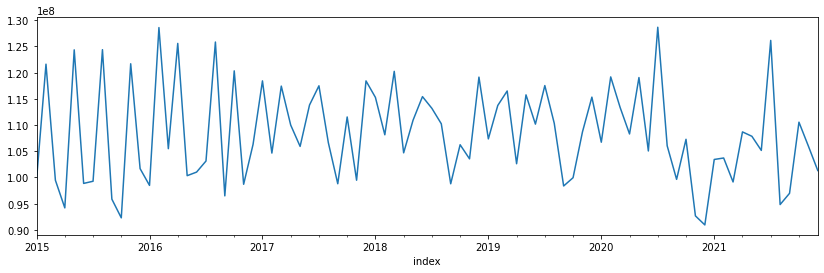

12 W2 Revenue


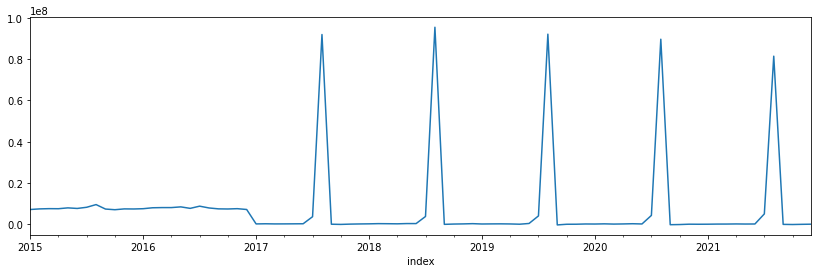

13 Delivery Revenue


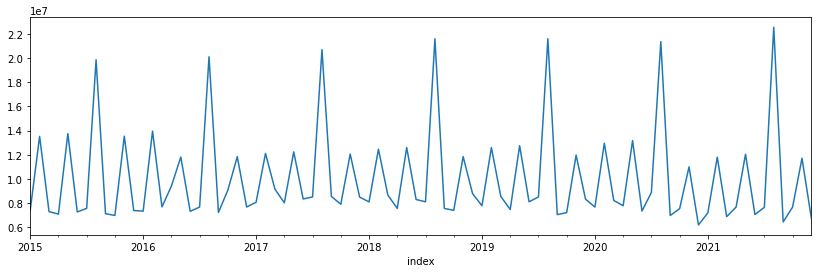

14 ASO Allocation


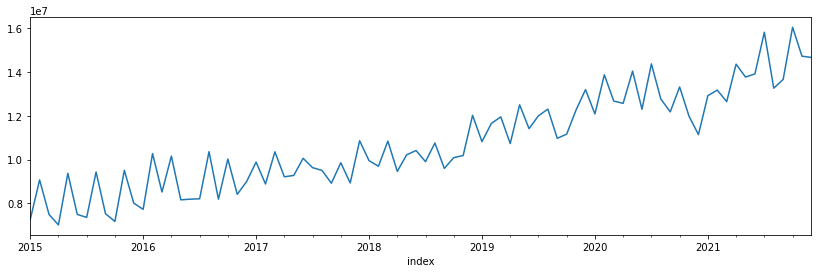

15 Other Processing Revenue


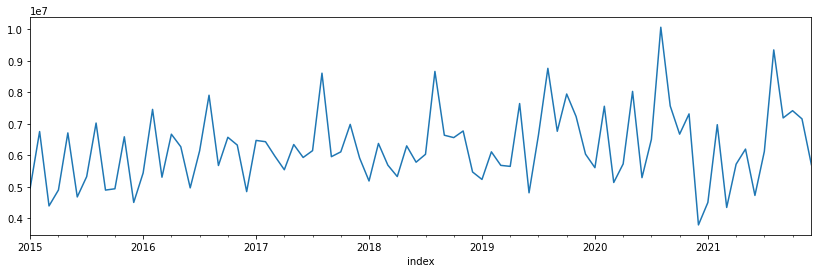

16 SurePayroll


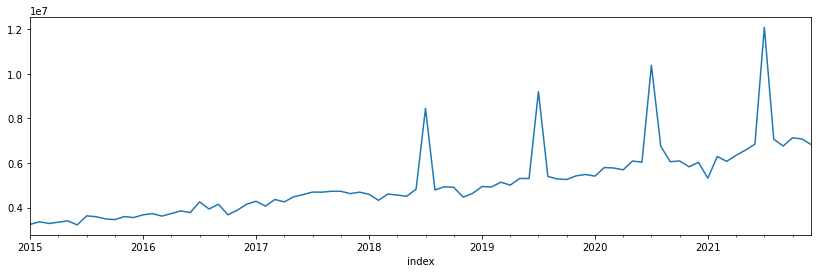

17 Total International


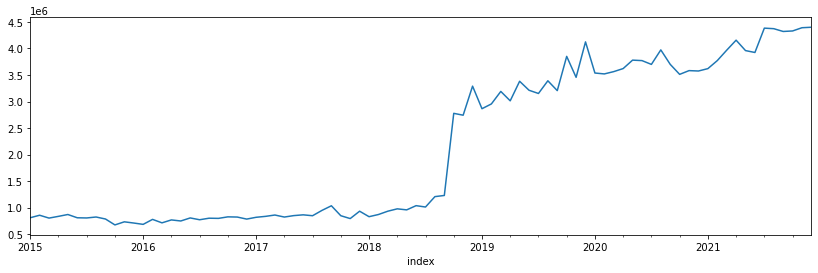

20 Total 401k


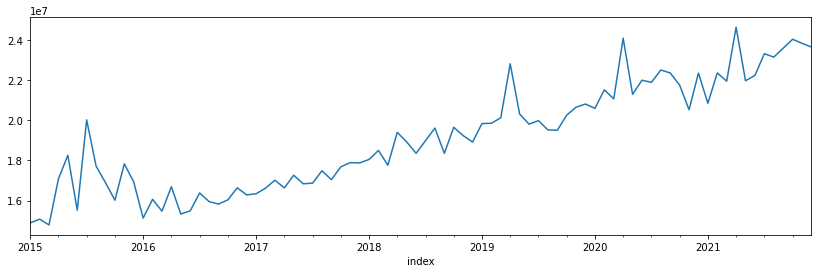

31 HR Solutions (excl PEO)


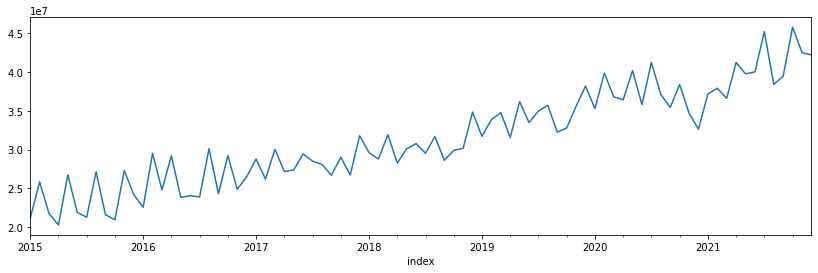

40 Total Online Services


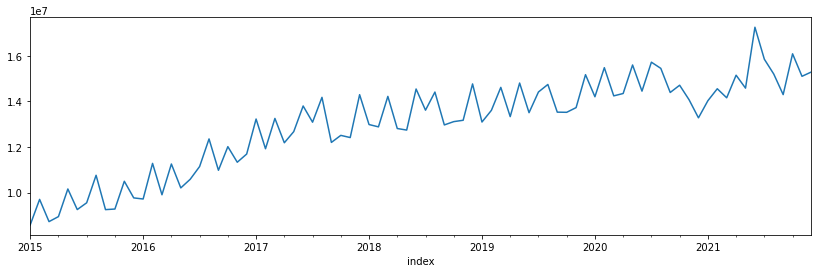

50 Other Managment Solutions


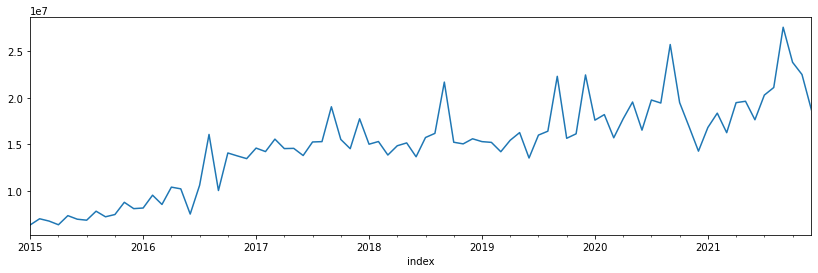

60 Total PEO


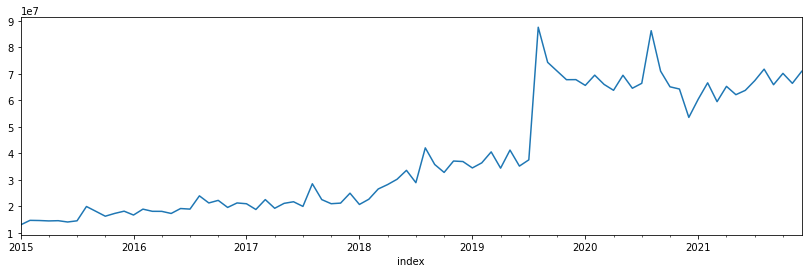

70 Total Insurance Services


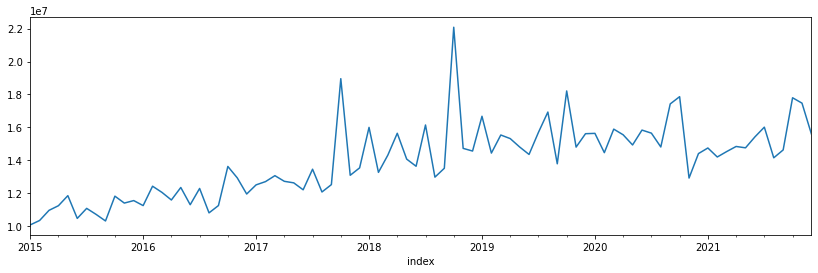

Total Revenue


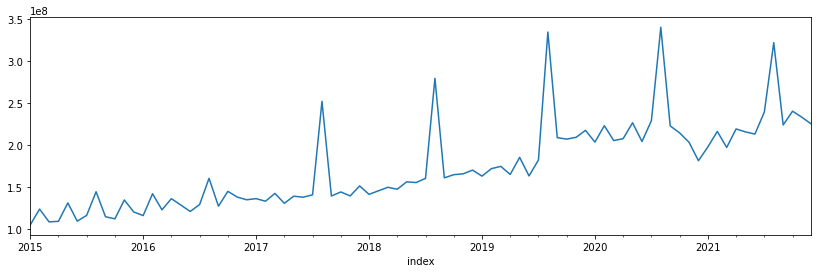

In [167]:
for c in df_month.columns:
    print(c)
    fig, ax = plt.subplots(figsize=(14,4))
    df_month[c].plot(ax=ax)
    #sns.lineplot(data=df_month[c])
    plt.show()